target_native_gates = ['Hadamard','RX','RY','RZ','CNOT']

In [1]:
import pennylane as qml
from qiskit import transpile as qiskit_transpiler
import pandas as pd
from qco_level_0 import *
# from qco_level_1 import optimization_level_1, optimization_level_1_homo
from qco_level_1 import *
from qco_level_2 import optimization_level_2
from qco_level_3 import optimization_level_3
from qco_spec_table import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
[ds] = qml.data.load("ketgpt")

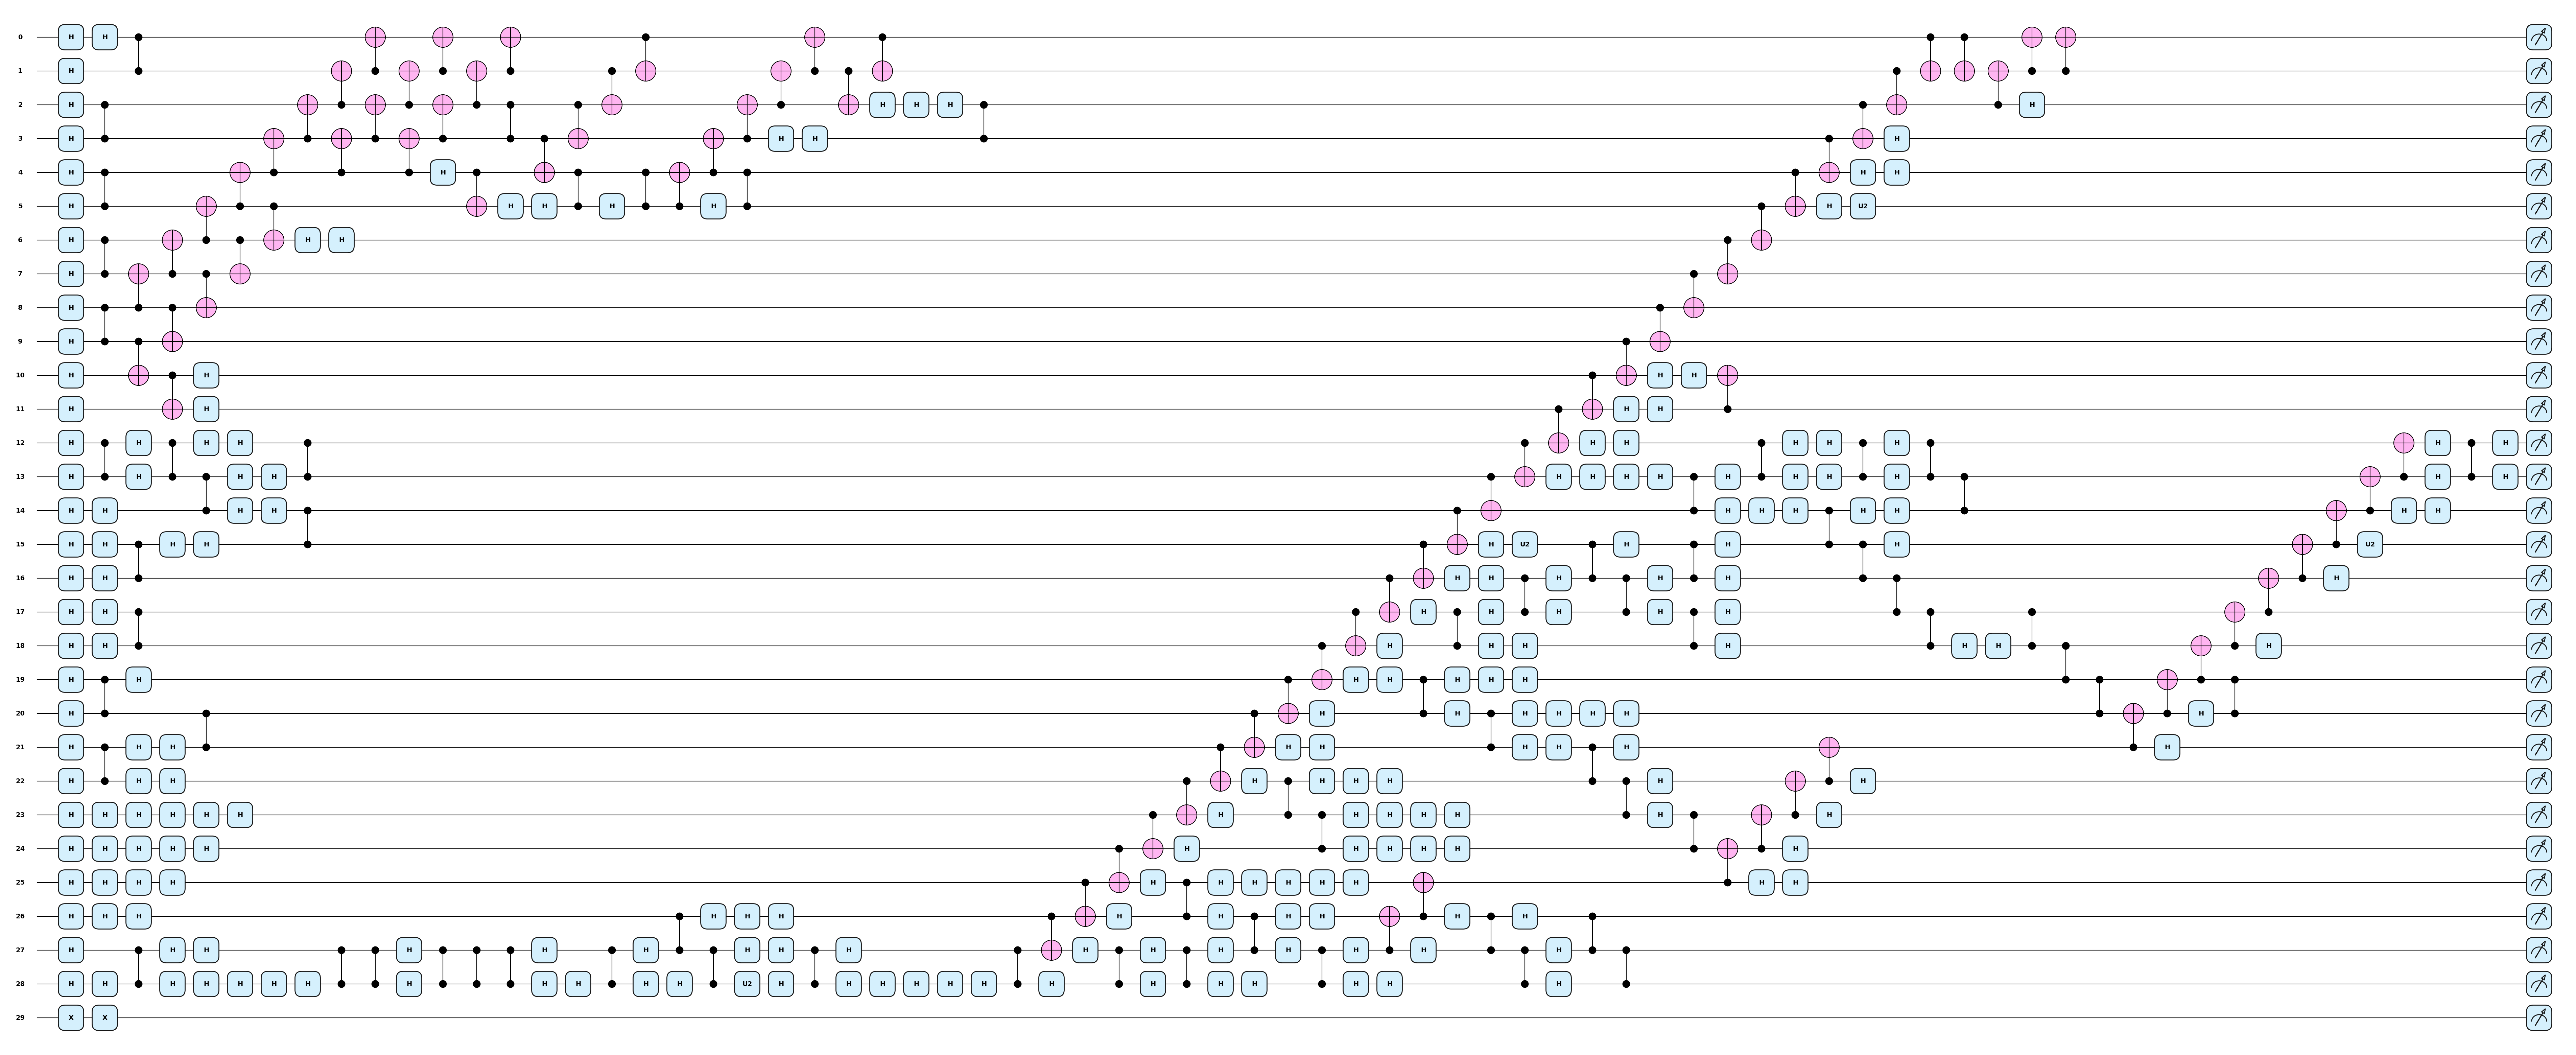

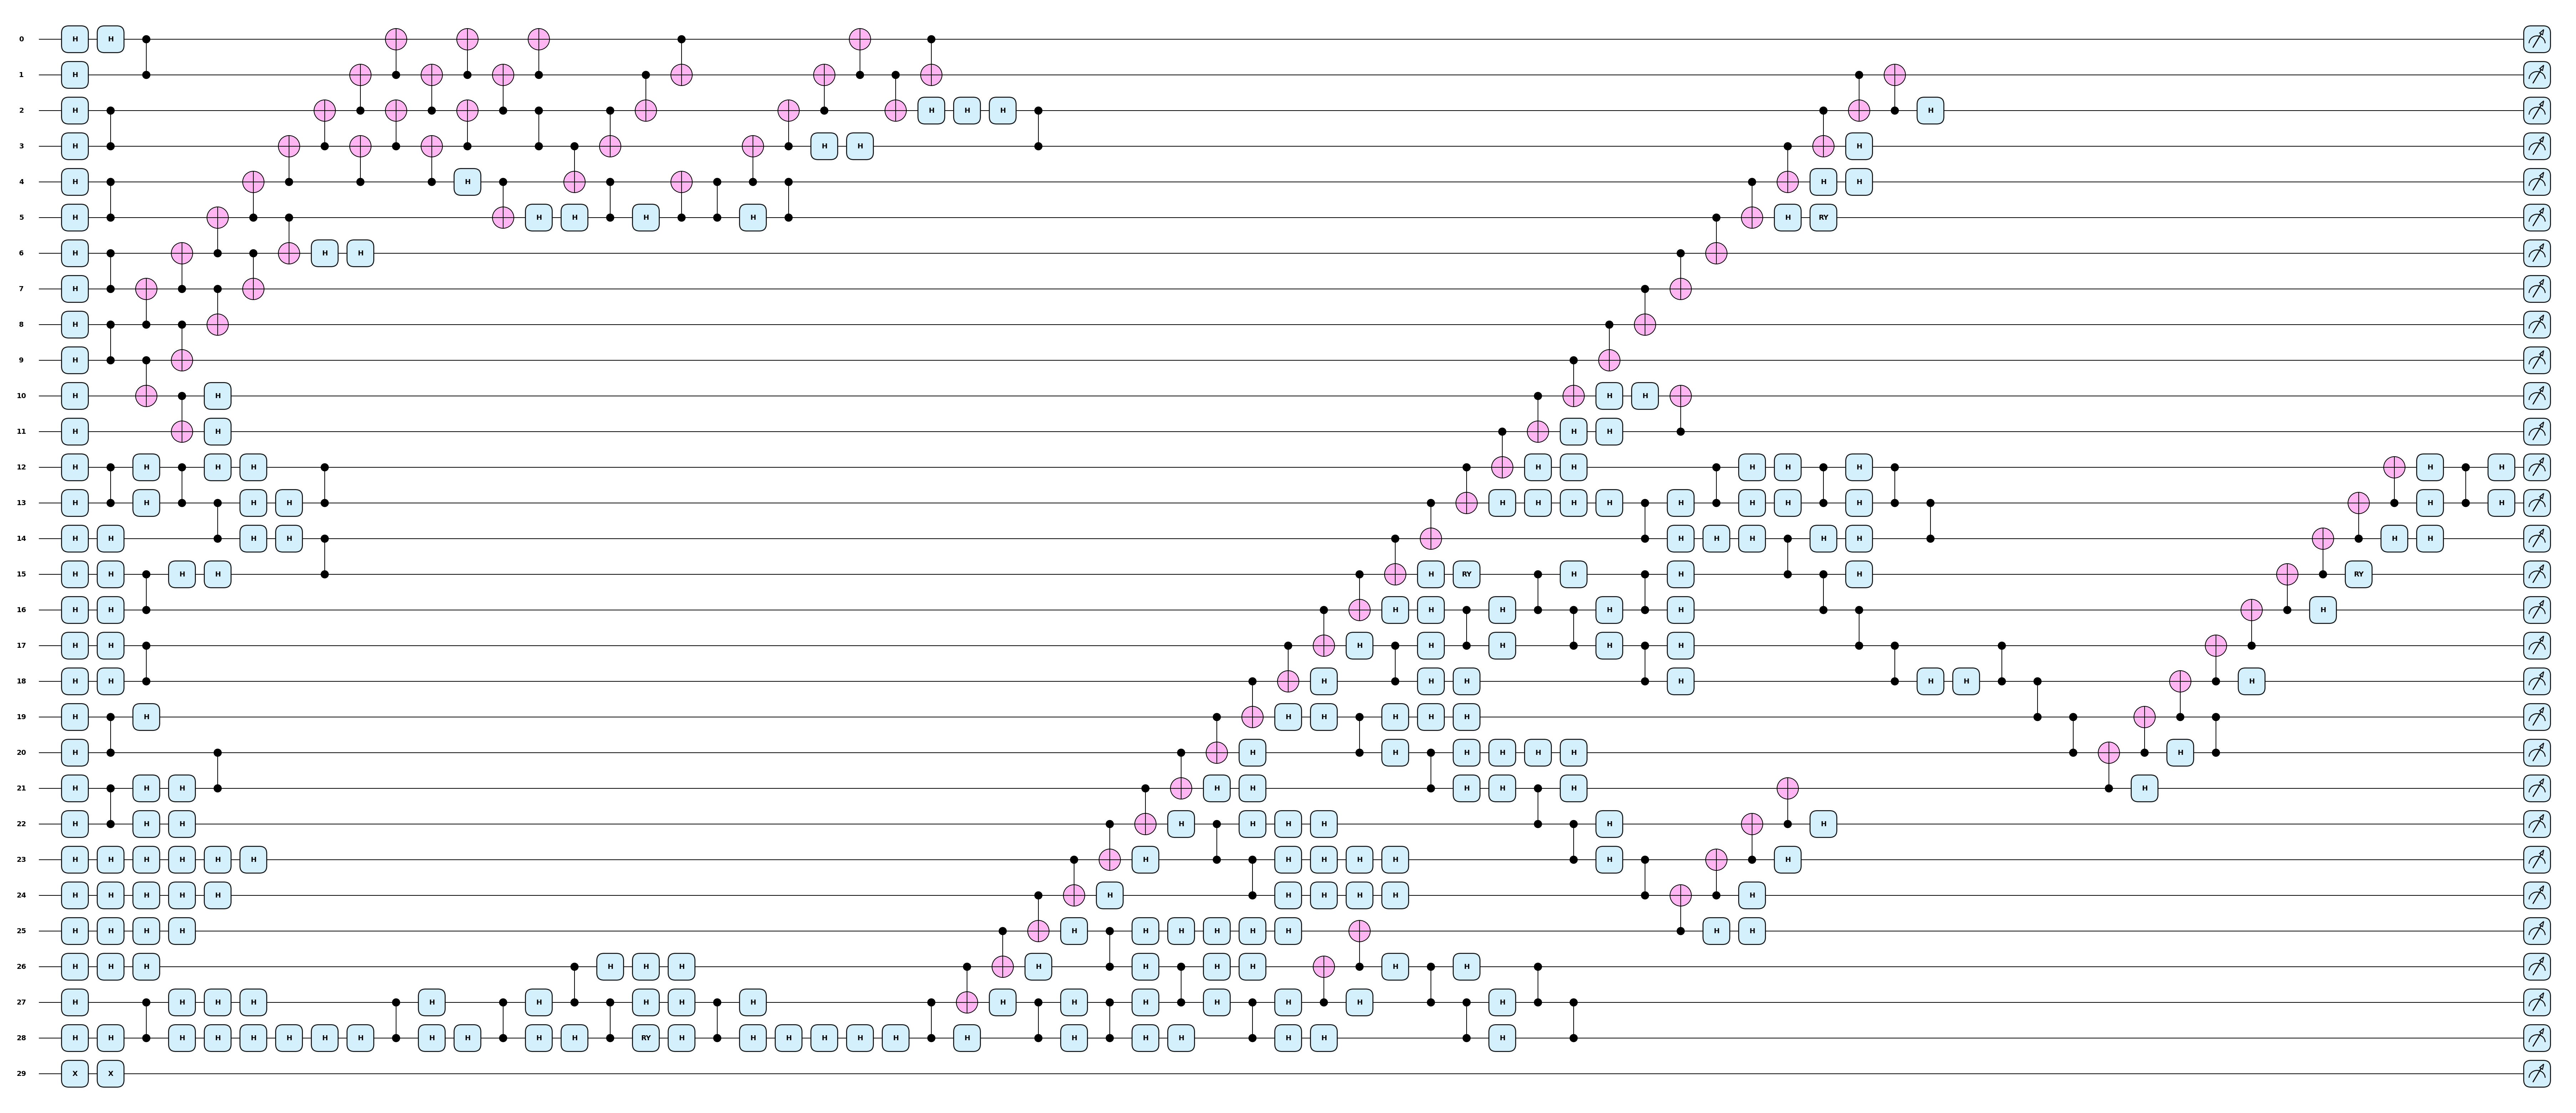

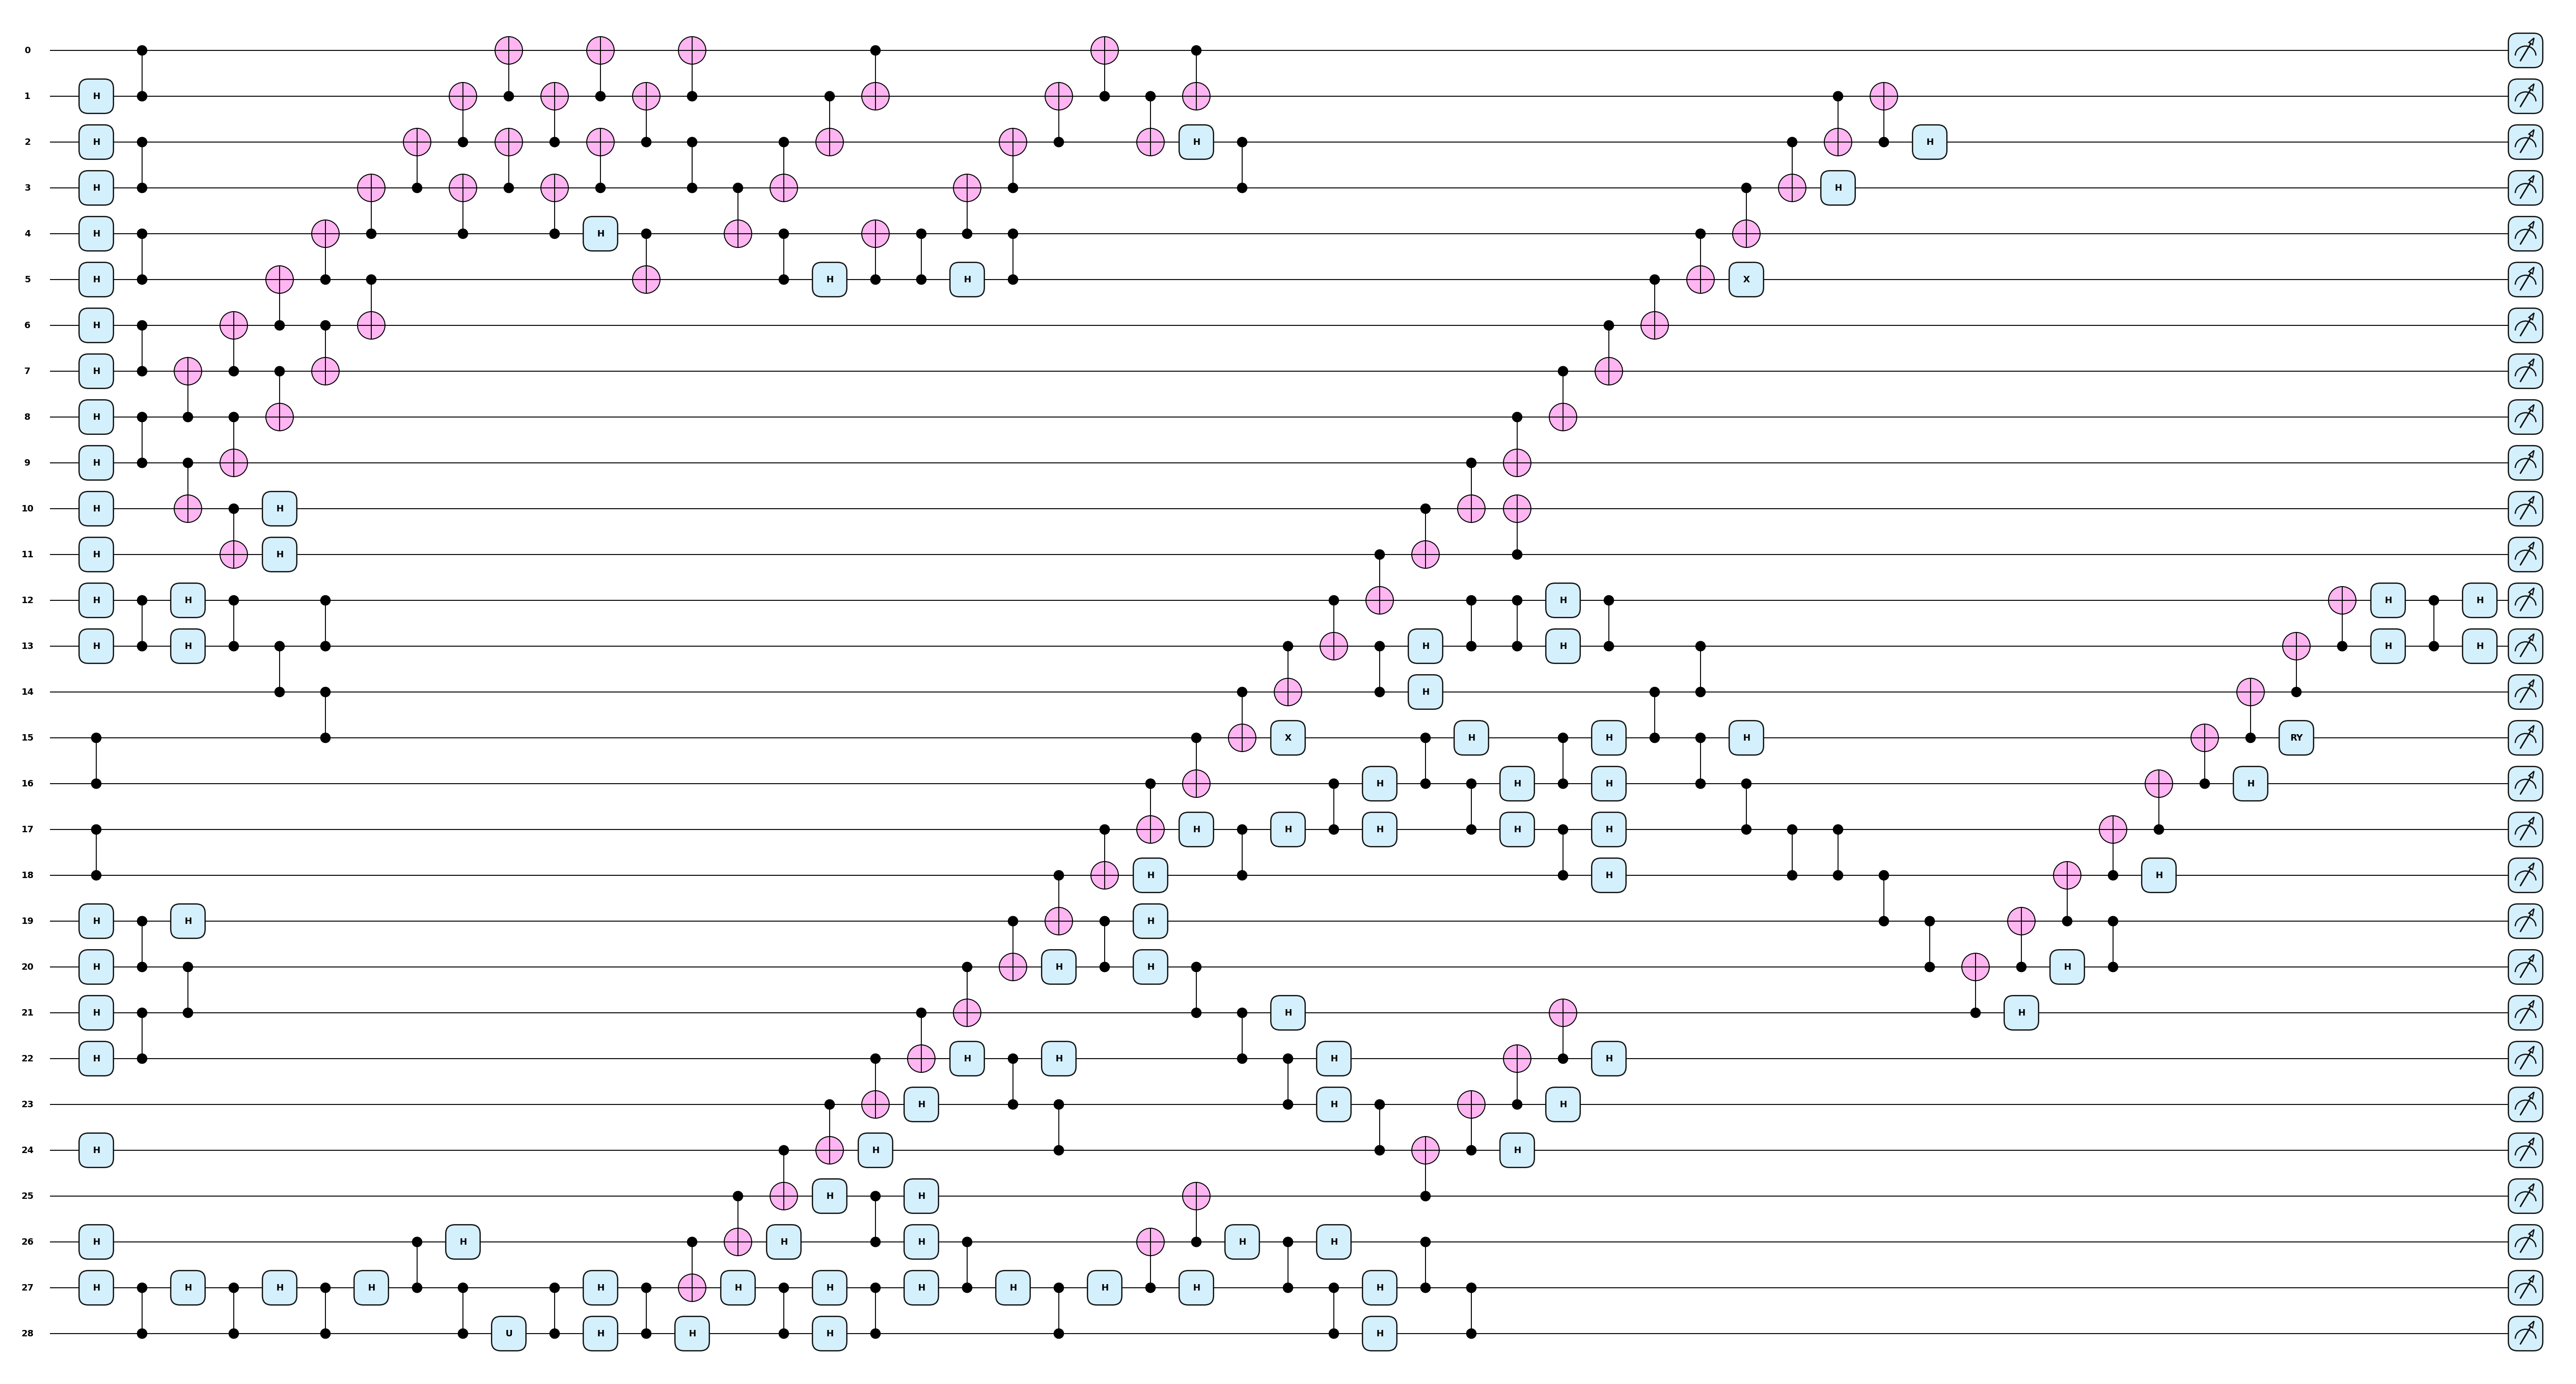

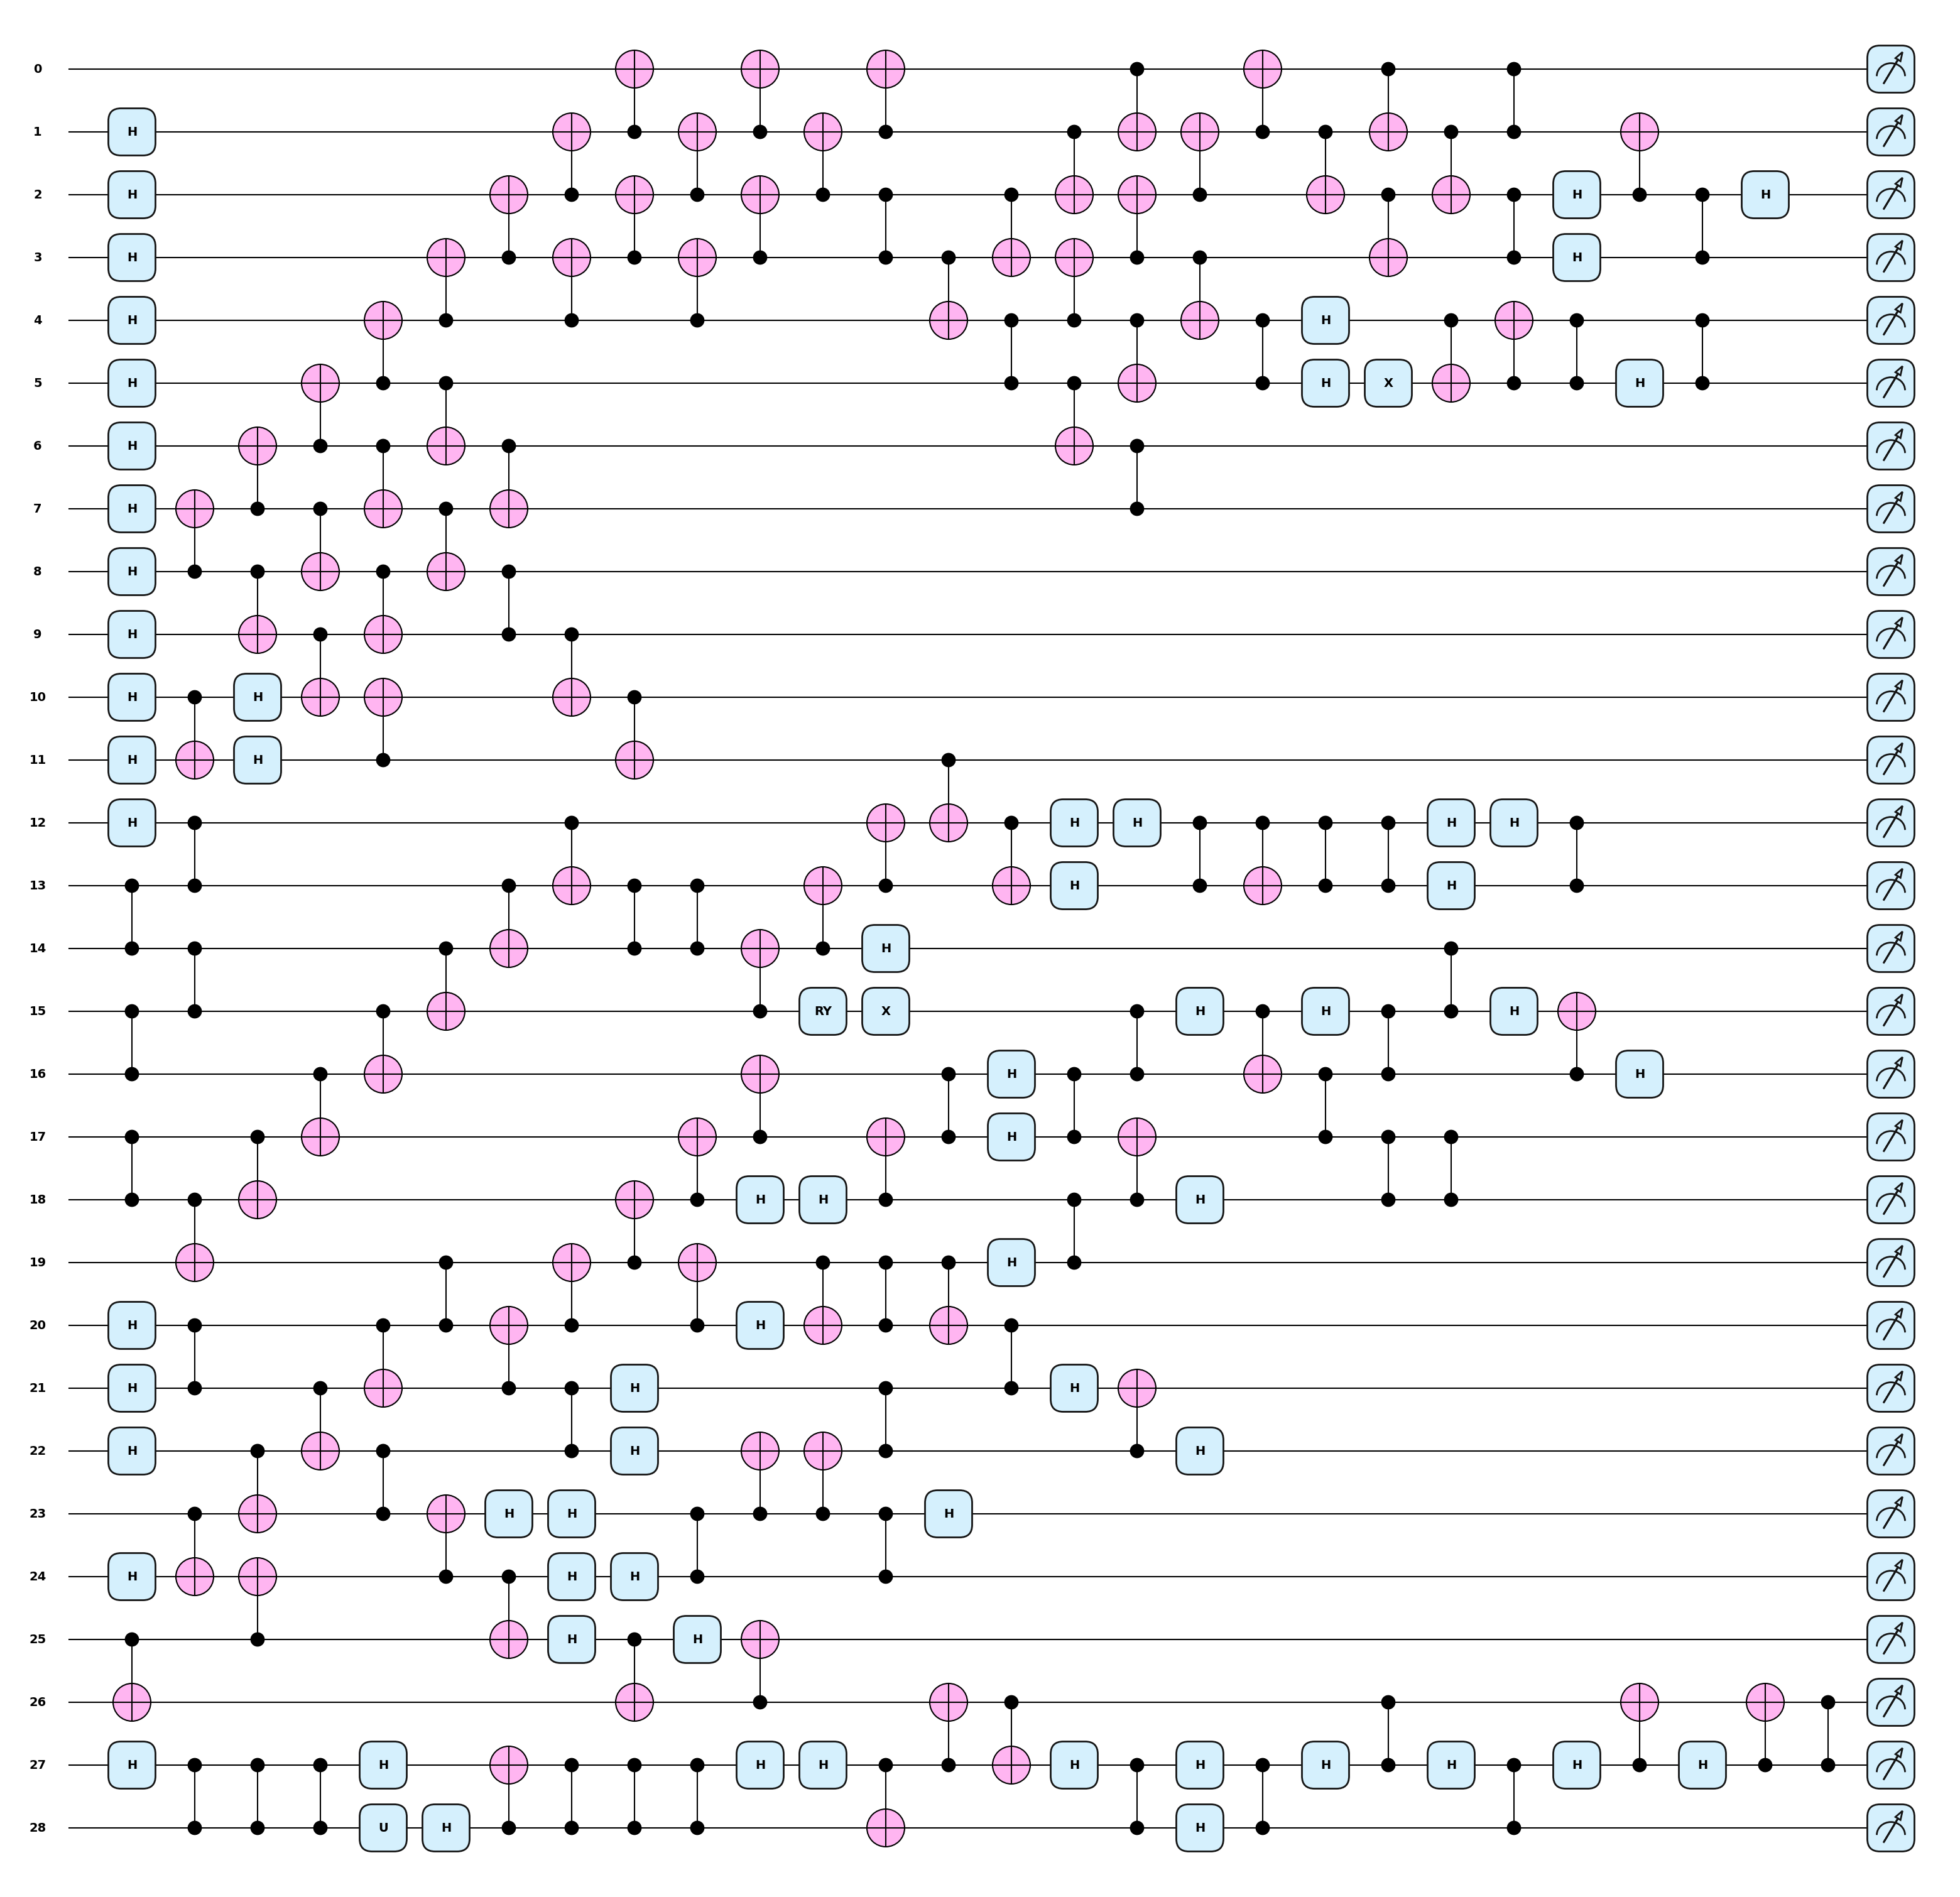

In [3]:
# example
seed = 1
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

show_circuit(circuit)
show_circuit(optimization_level_2(circuit)) # 2-qubit gates
show_circuit(optimization_level_1(optimization_level_2(circuit))) # 1-qubit gates
show_circuit(optimization_level_3(optimization_level_1(optimization_level_2(circuit)))) # 1- and 2-qubit gates

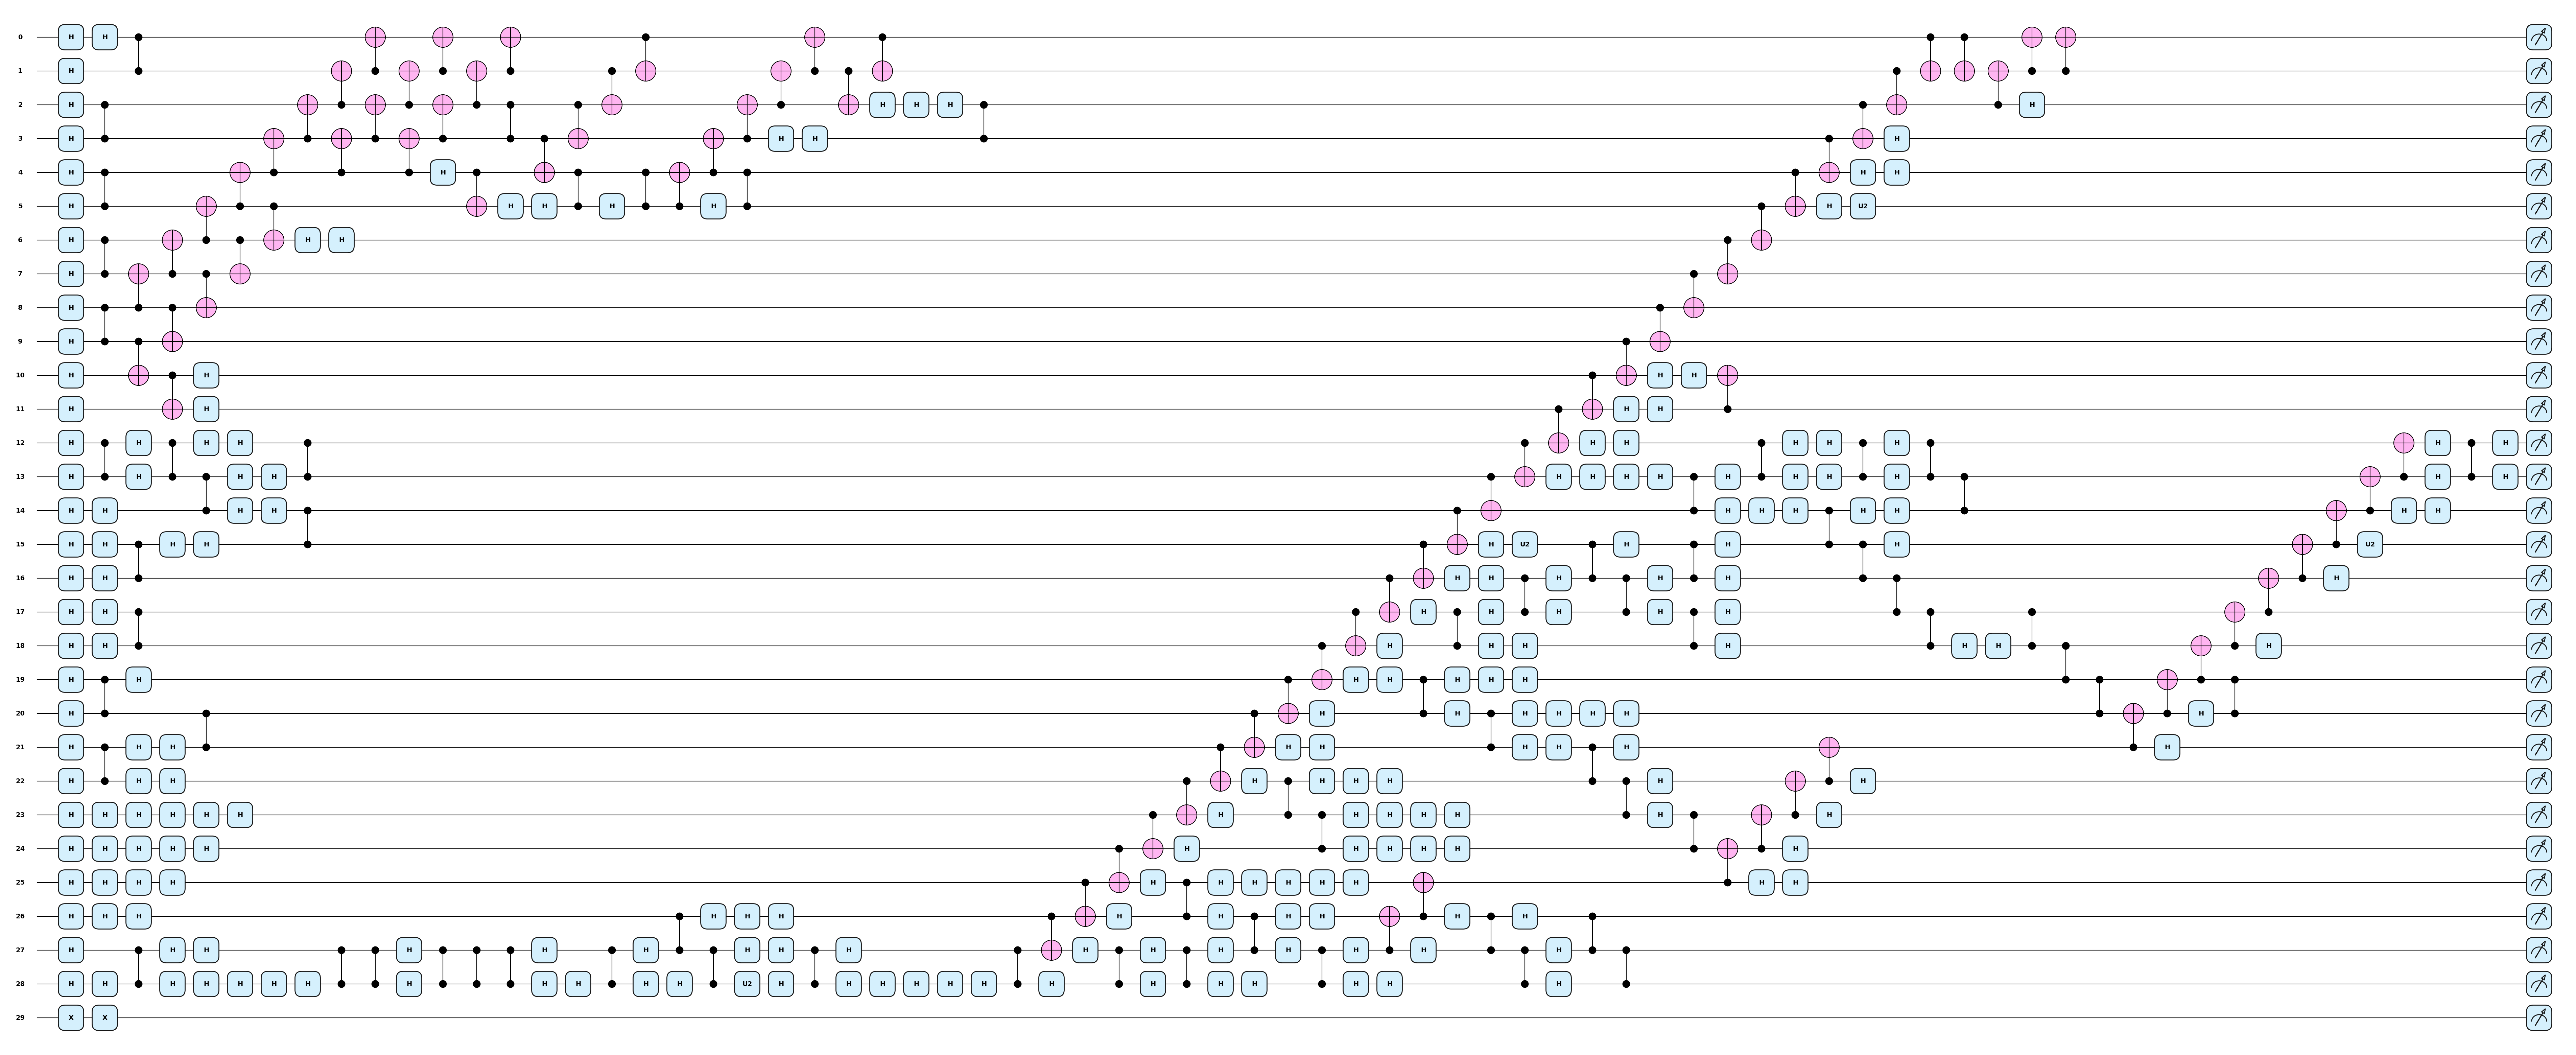

qiskkit optimization level 3


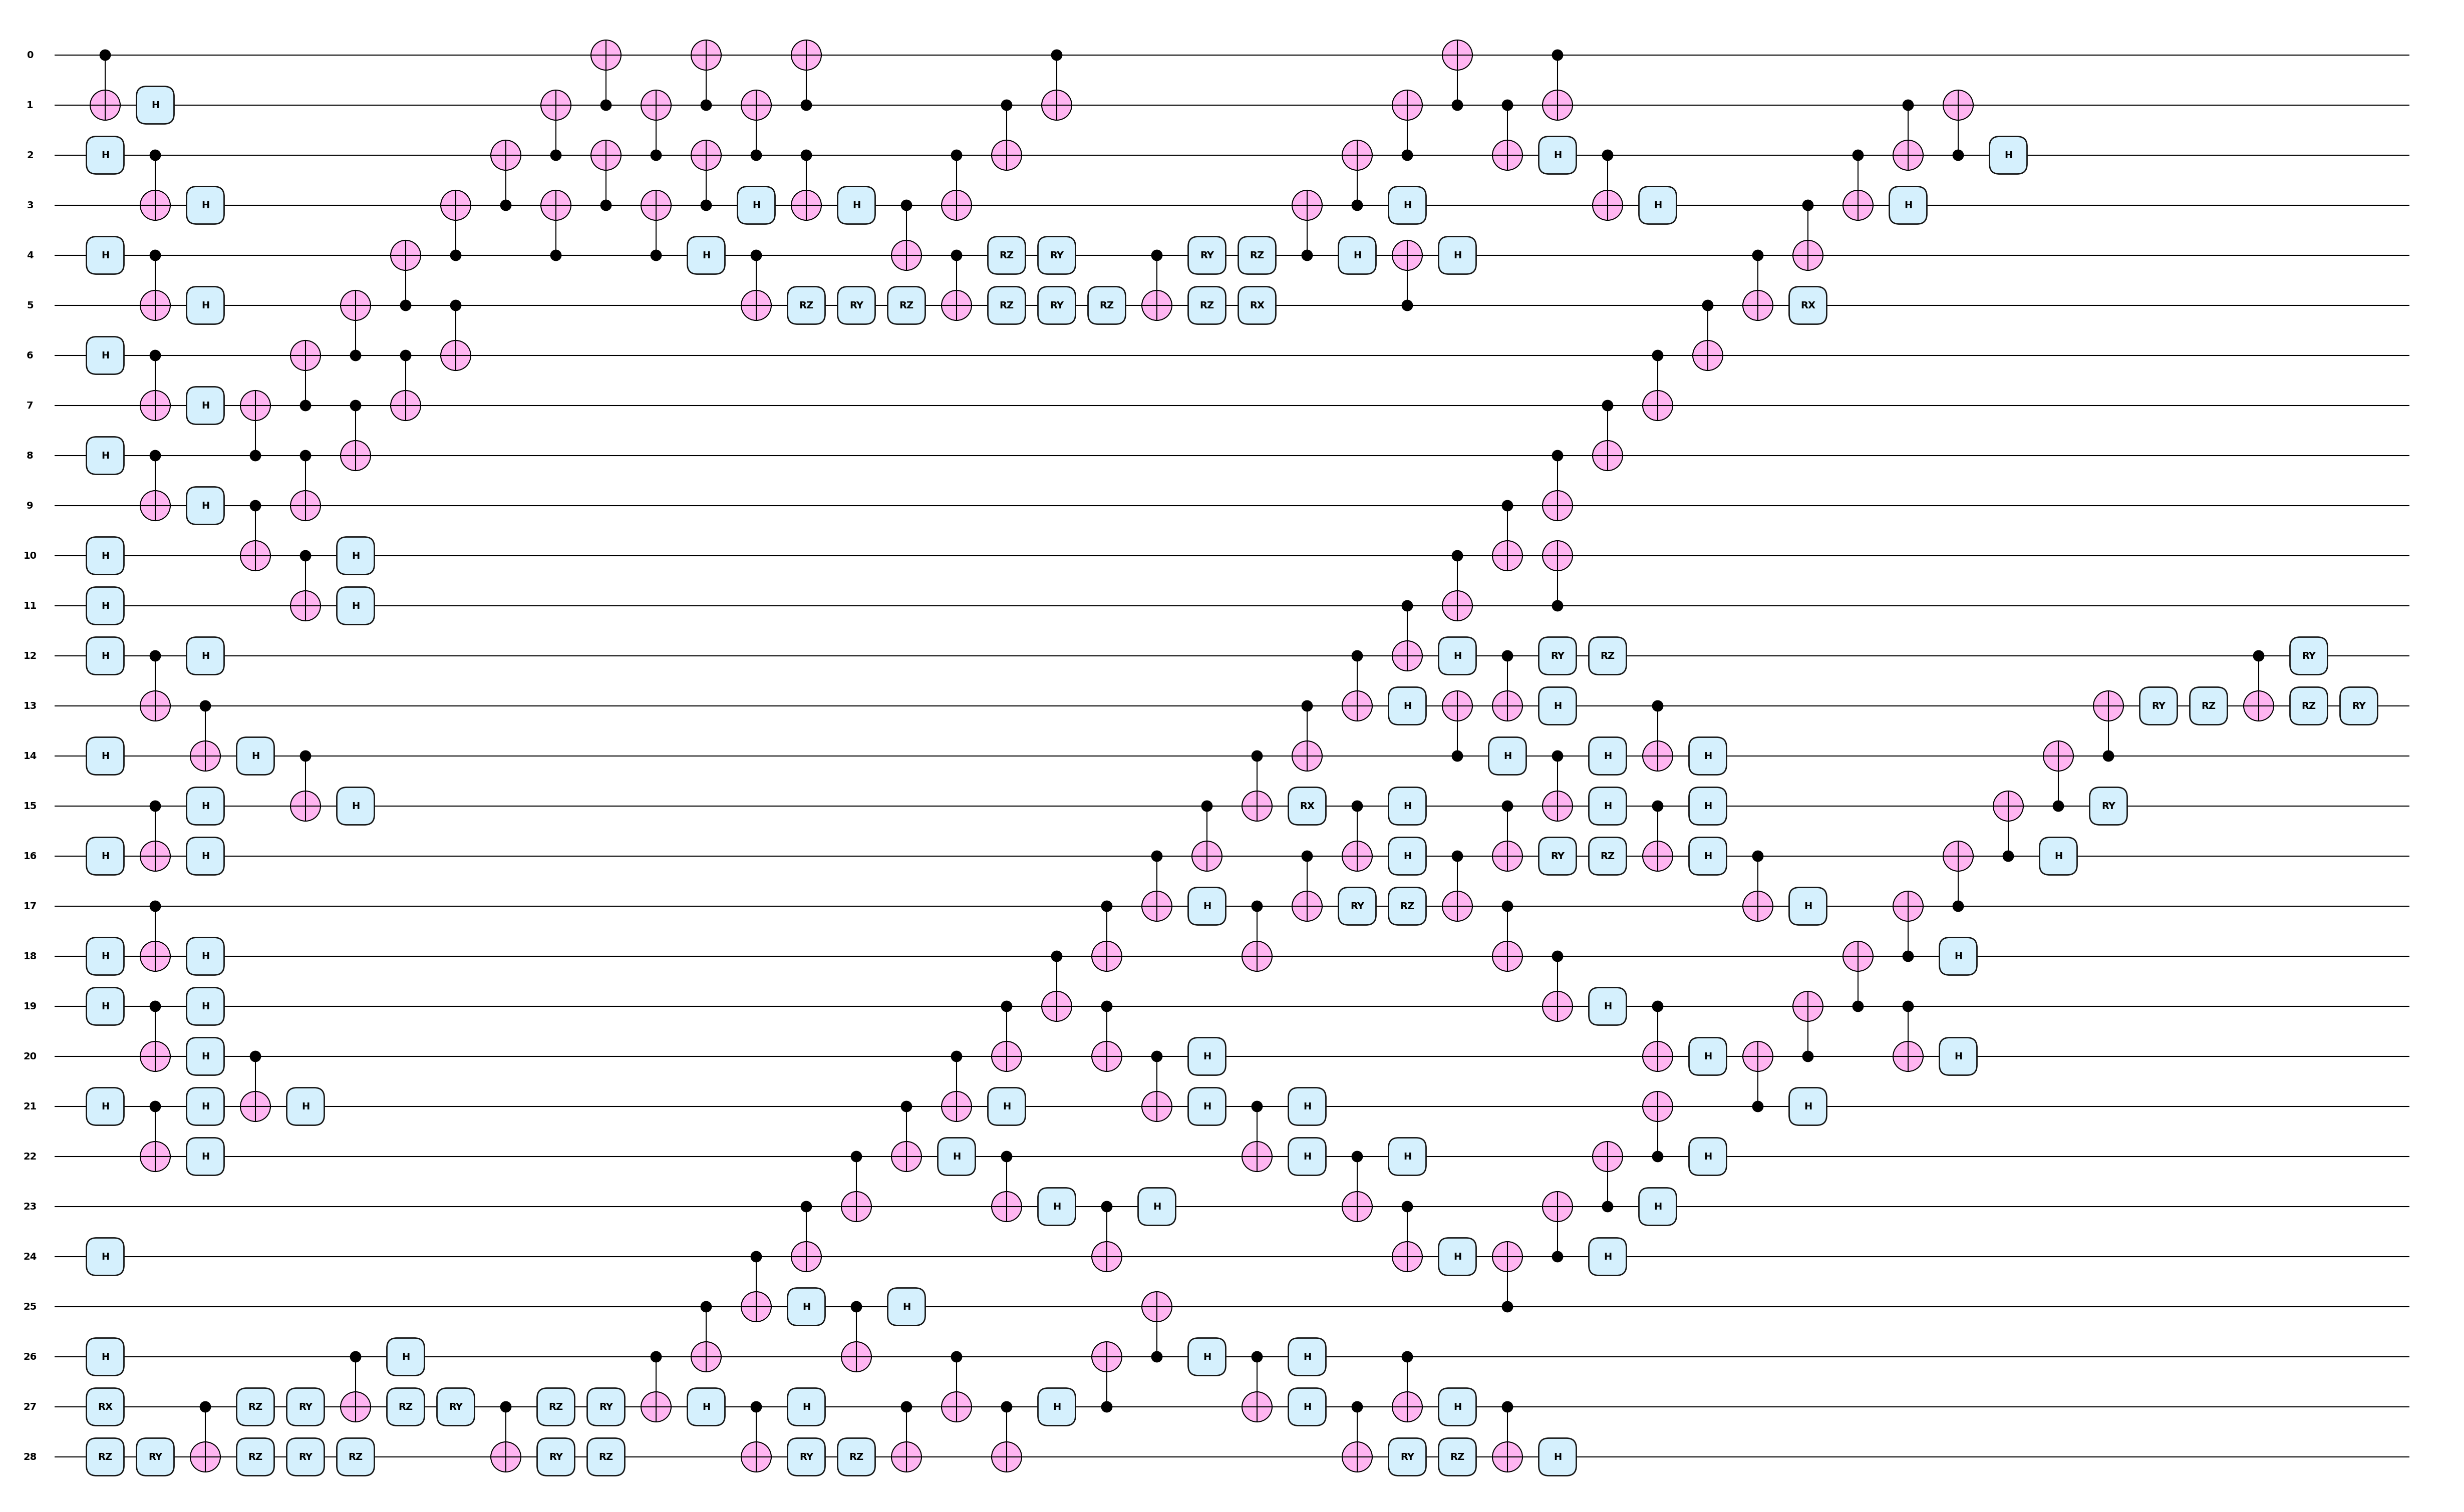

penny


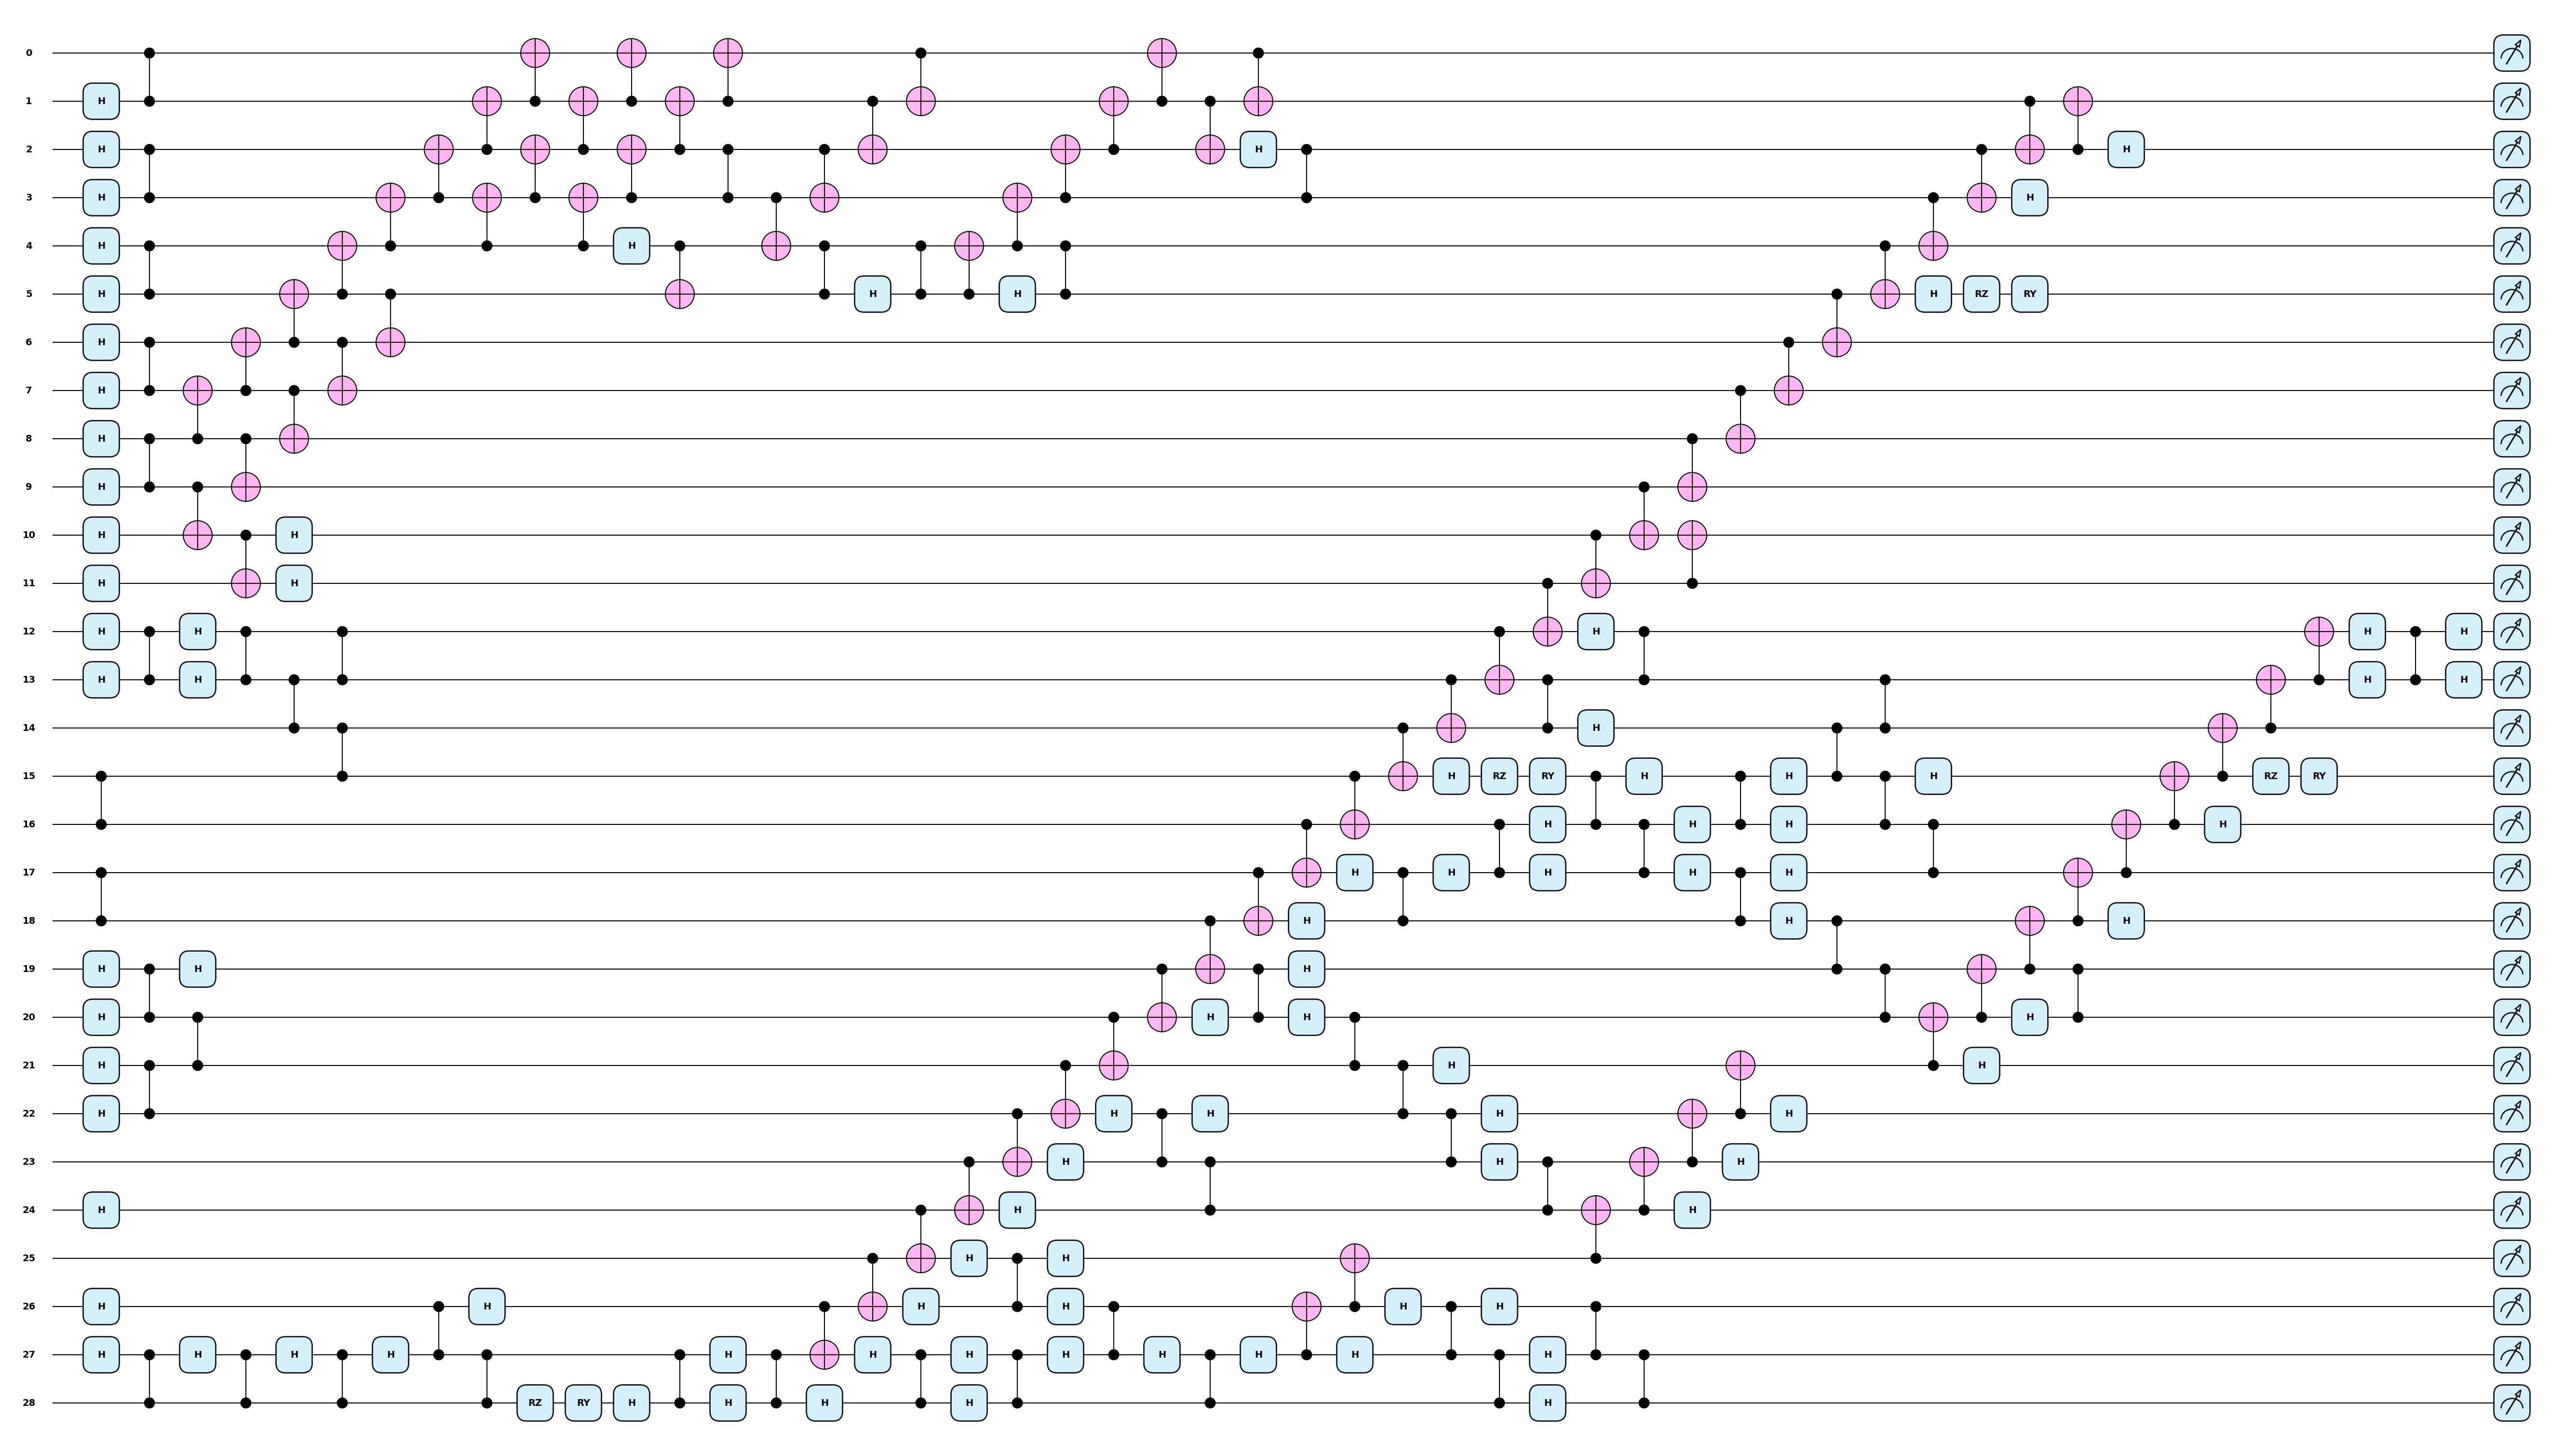

mine


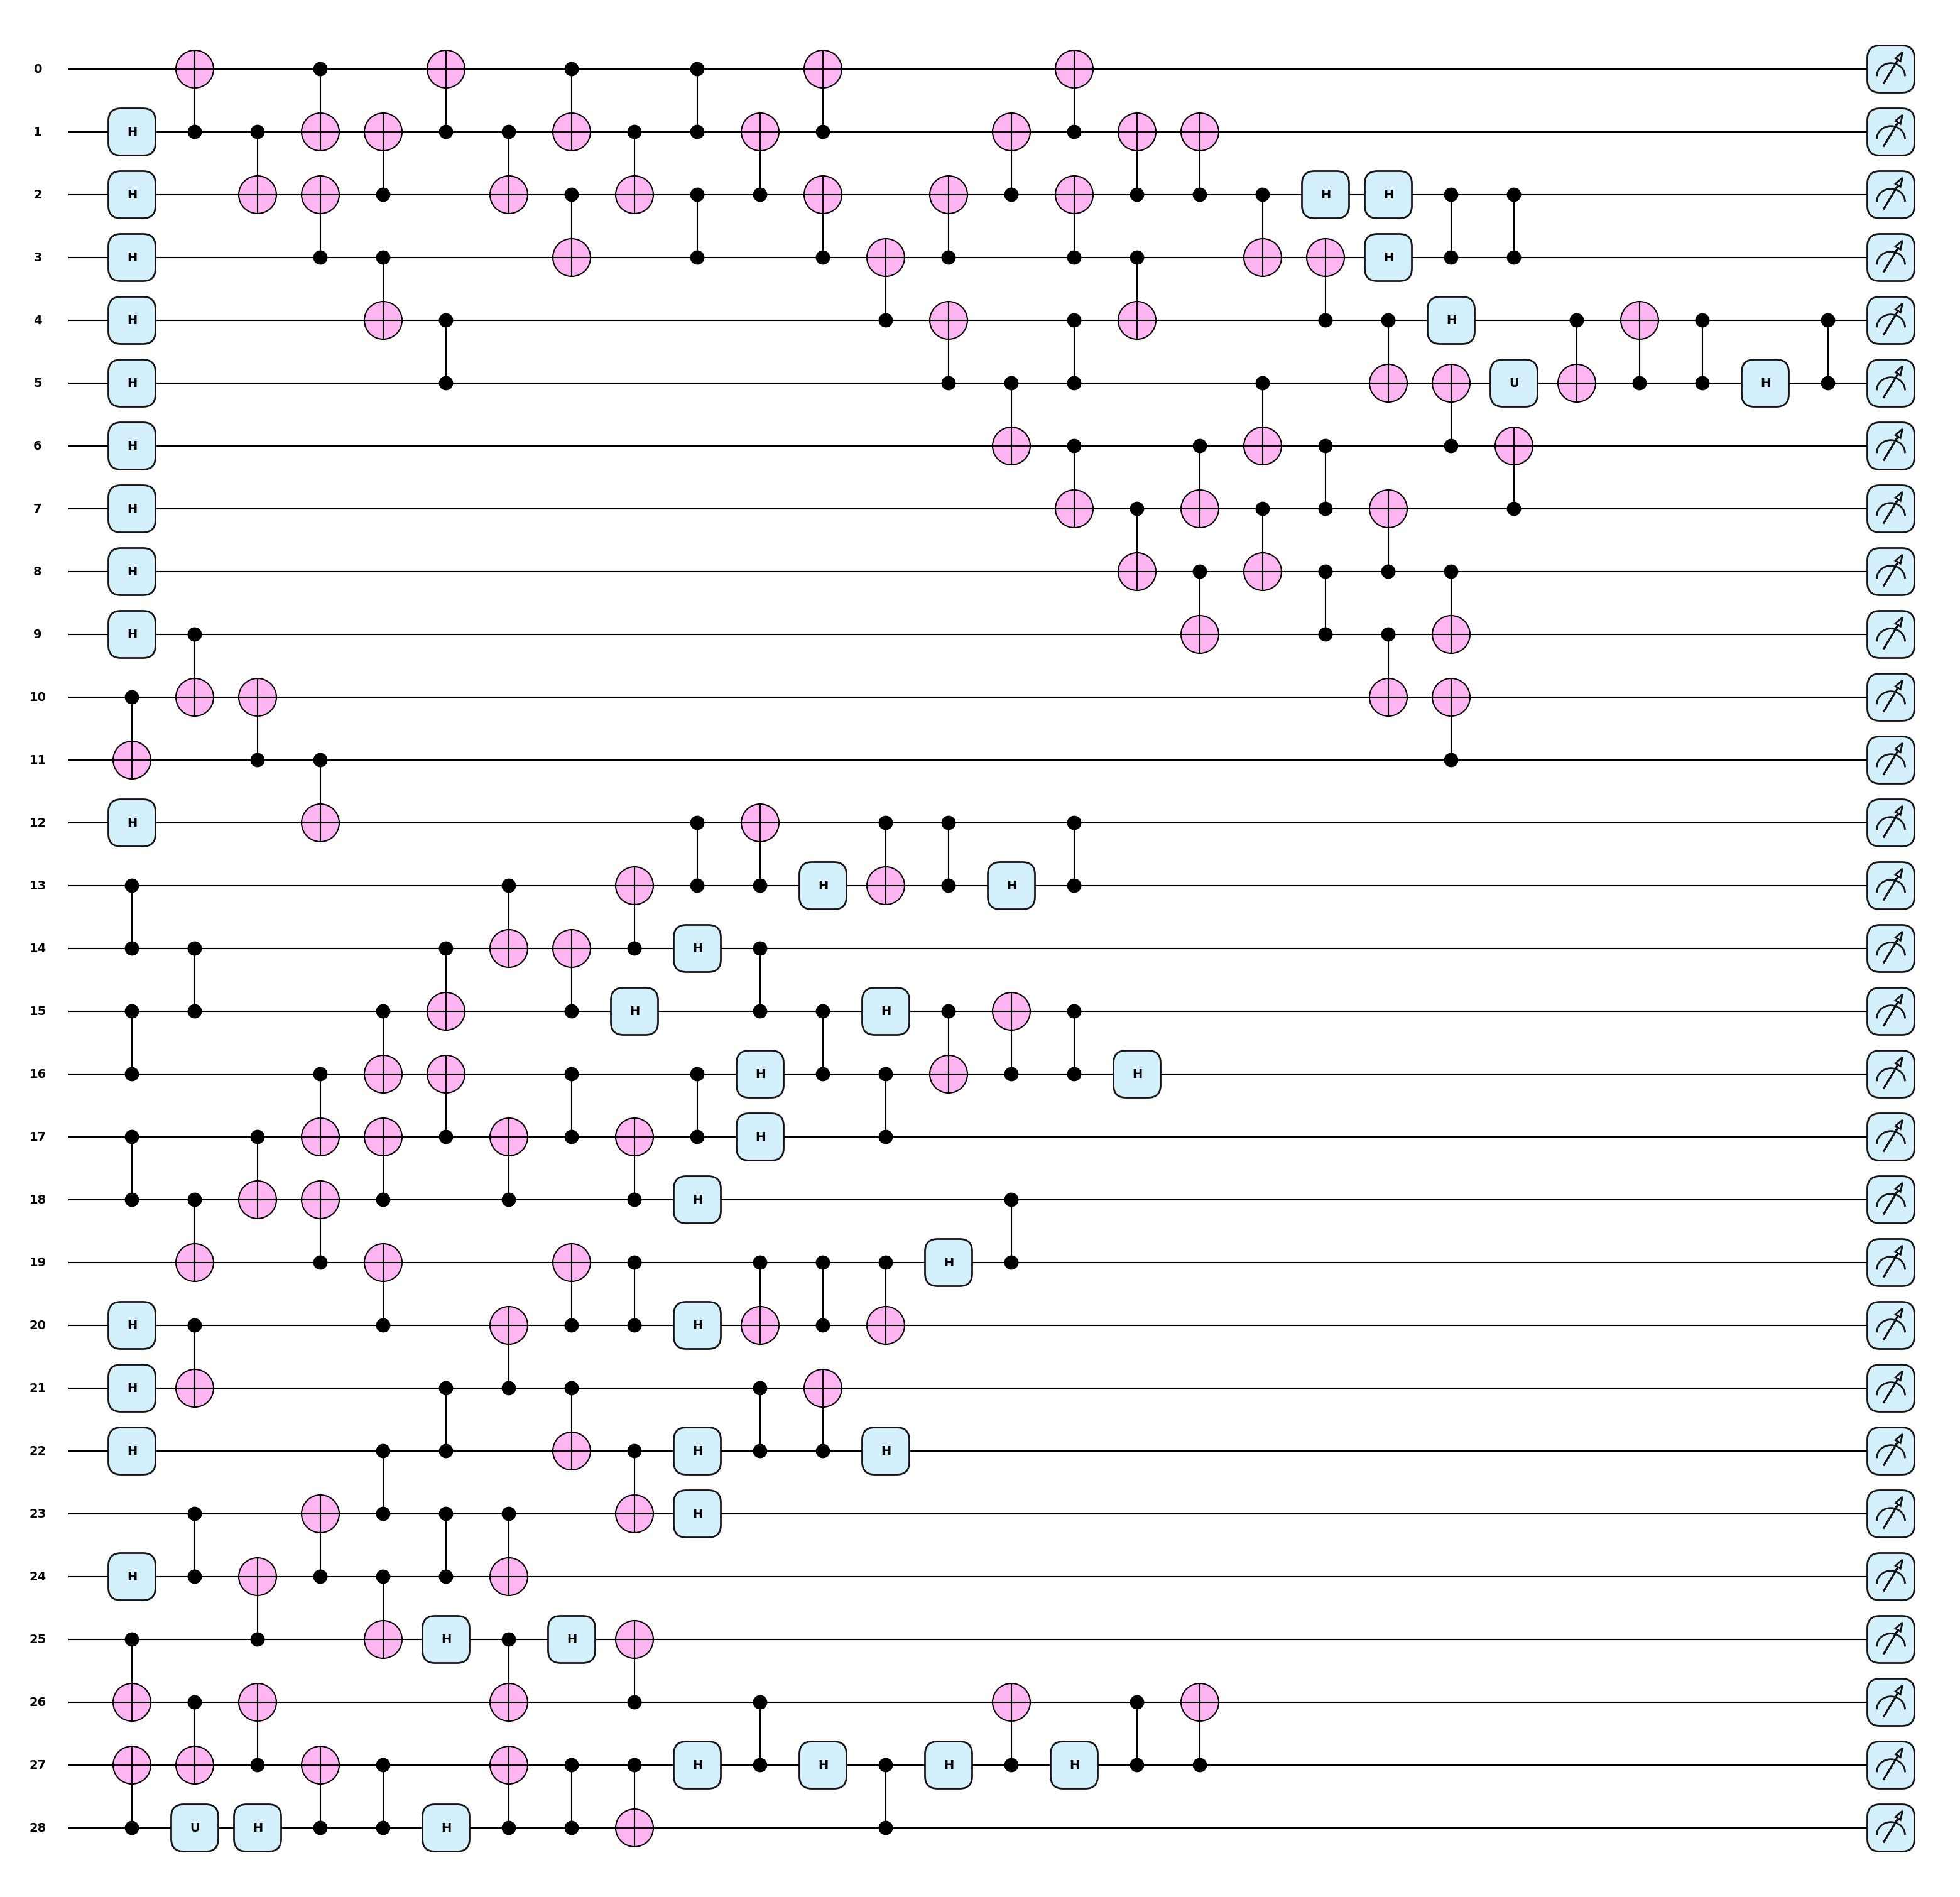

In [5]:
show_circuit(circuit)
print('qiskkit optimization level 3')
transpiled_qc = qiskit_transpiler(to_qc(circuit), basis_gates=['h', 'rx', 'ry', 'rz', 'cx'], optimization_level=3)
show_circuit(qml.from_qiskit(transpiled_qc))
print('penny')
show_circuit(penny_loop(circuit))
print('mine')
mine = my_loop(circuit, optimization_level_1, optimization_level_2, optimization_level_3)
show_circuit(mine)

In [6]:
make_spec_table_loop(circuit, optimization_level_1,  optimization_level_2, optimization_level_3)

,Original,Qiskit,PennyLane,Levels 3+2+1
gates,380,224,236,165
1q gates,232,92,100,43
2q gates,148,132,136,122
depth,73,45,50,28
gate types,5,5,5,4


In [7]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        df = make_spec_table_loop(circuit, optimization_level_1, optimization_level_2, optimization_level_3)
        dfs.append(df)
    except:
        pass

In [8]:
len(dfs)                                    

1000

In [9]:
dfs[0]

,Original,Qiskit,PennyLane,Levels 3+2+1
gates,141,37,38,31
1q gates,116,18,19,12
2q gates,25,19,19,19
depth,32,16,16,12
gate types,5,4,5,4


In [10]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    dfs_ratio.append(df.div(df['Original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='Original') for df in dfs_ratio]
dfs_ratio[0]

,Qiskit,PennyLane,Levels 3+2+1
gates,0.262,0.270,0.220
1q gates,0.155,0.164,0.103
2q gates,0.760,0.760,0.760
depth,0.500,0.500,0.375
gate types,0.800,1.000,0.800


In [11]:
for df in dfs_ratio:
    df.rename(columns={'Levels 2+1':'Levels 3+2+1'}, inplace=True)
dfs_ratio[0]

,Qiskit,PennyLane,Levels 3+2+1
gates,0.262,0.270,0.220
1q gates,0.155,0.164,0.103
2q gates,0.760,0.760,0.760
depth,0.500,0.500,0.375
gate types,0.800,1.000,0.800


In [12]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

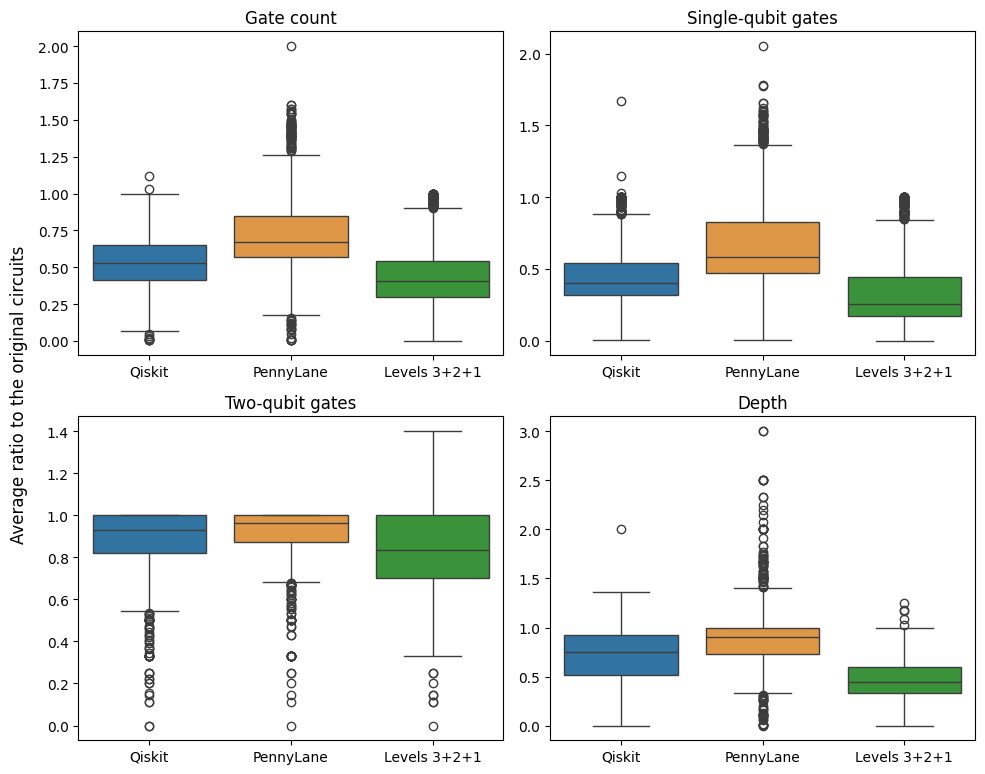

In [13]:
# fig 1
fig, axes = plt.subplots(2,2, figsize=(10, 8))
for i, metric in enumerate(['gates', '1q gates', '2q gates','depth']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': "#f7992e", 'Levels 3+2+1': '#2ca02c'}) # 'Qiskit\n(pattern matching)':'#7b1fb4', 'PennyLane': '#ff7f0e'
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gates')
    elif i==2:
        ax.set_title('Two-qubit gates')
    elif i==3:
        ax.set_title('Depth')
    ax.set_xlabel('')
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [14]:
mean_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean','std']).reset_index()
mean_df['mean_percent'] = (1-mean_df['mean'])*100
mean_df

,method,metric,mean,std,mean_percent
0,Levels 3+2+1,1q gates,0.343404,0.242071,65.659600
1,Levels 3+2+1,2q gates,0.813018,0.175525,18.698182
2,Levels 3+2+1,depth,0.482030,0.210711,51.797000
3,Levels 3+2+1,gate types,1.264203,0.289830,-26.420300
4,Levels 3+2+1,gates,0.448056,0.211666,55.194400
5,PennyLane,1q gates,0.682567,0.326952,31.743300
6,PennyLane,2q gates,0.907309,0.140327,9.269091
7,PennyLane,depth,0.914834,0.353789,8.516600
8,PennyLane,gate types,1.118182,0.171971,-11.818200
9,PennyLane,gates,0.733234,0.275035,26.676600


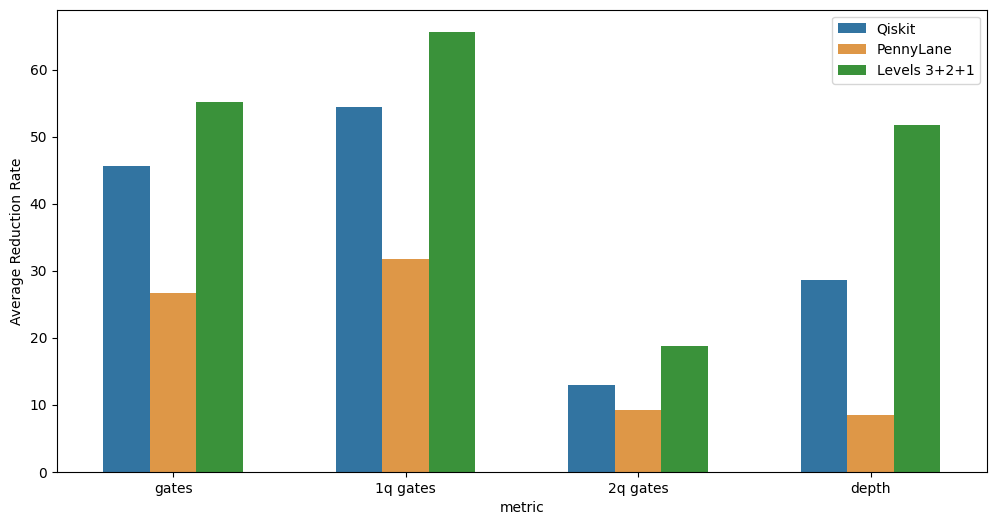

In [30]:
# Drop rows where metric == 'gate types'
df_filtered = mean_df[mean_df["metric"] != "gate types"]

palette = {
    'Qiskit': '#1f77b4',
    'PennyLane': '#f7992e',
    'Levels 3+2+1': '#2ca02c'
}

method_order = ["Qiskit", "PennyLane", "Levels 3+2+1"]
metric_order = ["gates", "1q gates", "2q gates", "depth"]

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_filtered,
    x="metric",
    y="mean_percent",
    hue="method",
    hue_order=method_order,
    order=metric_order, 
    palette=palette,
    errorbar="sd",
    width=0.6
)

plt.ylabel("Average Reduction Rate")
plt.legend()
plt.show()